## Supervised machine learning to predict used vehicles prices
#### Using data from craigslist.org

For this Capnstone project I'm using Used Cars Dataset from kaggle https://www.kaggle.com/austinreese/craigslist-carstrucks-data. Dataset contains ~500K records  about used cars and their prices collected from craigslist
The goal of this project is build a model using supervised machine learning algorithms to predict prices of used vehicles.


In [273]:
#importing necessary modules

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
from wordcloud import WordCloud

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso,  ElasticNet 
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

from scipy.stats import jarque_bera
from scipy.stats import normaltest

import warnings
warnings.filterwarnings(action="ignore")
import time

import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [6]:
#data location - https://www.kaggle.com/austinreese/craigslist-carstrucks-data/download
df_raw_data=pd.read_csv('craigslist-carstrucks-data.zip', compression='zip')
print(df_raw_data.shape)
df_raw_data.head(3)


(550313, 22)


,url,city,city_url,price,year,manufacturer,make,condition,cylinders,fuel,...,transmission,VIN,drive,size,type,paint_color,image_url,desc,lat,long
0,https://abilene.craigslist.org/cto/d/aspermont...,"abilene, TX",https://abilene.craigslist.org,9000,2009.0,chevrolet,suburban lt2,good,8 cylinders,gas,...,automatic,1GFNC26099R211276,rwd,full-size,SUV,white,https://images.craigslist.org/00909_5P6f1E6zHl...,2WD 1/2 ton\nLeather Captains Chairs\nIn good ...,33.130100,-100.234400
1,https://abilene.craigslist.org/ctd/d/liberty-h...,"abilene, TX",https://abilene.craigslist.org,31999,2012.0,ram,2500,NaN,NaN,diesel,...,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00u0u_24XW8uhLYP...,www.GETADIESEL.com\n2012 RAM 2500 SLT 4X4 MEGA...,30.648368,-97.862949
2,https://abilene.craigslist.org/ctd/d/liberty-h...,"abilene, TX",https://abilene.craigslist.org,16990,2003.0,ram,3500,NaN,NaN,diesel,...,manual,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00l0l_H1UKTJ4sTI...,www.GETADIESEL.com\n2003 DODGE RAM 3500 LARAMI...,30.648516,-97.862434


In [7]:
df_raw_data.columns

Index(['url', 'city', 'city_url', 'price', 'year', 'manufacturer', 'make',
       'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'desc', 'lat', 'long'],
      dtype='object')

## Data exploration and cleaning 

Dataset contain 550313 rows and 22 columns. First let's drop columns, which don't contain useful information for the model. Columns 'url', 'city_url' and 'image_url' contain post and image url  and unique for each record. 'VIN' column contains vehicle identification number is unique for every vehicle. 'desc' description of each post. Dataset also contains 'city' column together coordinates  of the location ('lat' and 'long'), that information is extra and unnecessary, so we drop 'city' column.

In [47]:
df_useful_columns = df_raw_data.drop(['url','city','city_url','VIN',
                                     'image_url','desc'],axis=1)
df_useful_columns.isna().sum()

price                0
year              1487
manufacturer     26915
make              9677
condition       250074
cylinders       218997
fuel              4741
odometer        110800
title_status      4024
transmission      4055
drive           165838
size            366256
type            159179
paint_color     180021
lat              11790
long             11790
dtype: int64

Checking resulting dataframe for nulls we can see that target variable 'price' does not contain any nulls, which is good. But if we look closer we can see a lot of records where price is less  10. We need to drop that records because are not useful for the model. Also we need to drop record where price is too high (>150K$) 

In [340]:
df_useful_columns=df_useful_columns[df_useful_columns['price']>10];
df_useful_columns=df_useful_columns[df_useful_columns['price']<150000];

Other columns have many nulls. Before dropping nulls let see if can fill some null values.  For some not numerical columns we can substitute null with 'unknown'. 

In [341]:
df_useful_columns['paint_color'].fillna('unknow',inplace=True)
df_useful_columns['condition'].fillna('unknow', inplace=True)
df_useful_columns['type'].fillna('unknow', inplace=True)

In [342]:
df_cars_nonulls=df_useful_columns.dropna()

### Feature engineering 

Dataset has two columns 'manufacture' which is vehicle brand and 'make' model of the vehicle. This two columns can be combined in one 'make_model' two avoid uncertainty if several brans use same model name. To reduce number of unique spelling of the model we need drop remove spaces,  - , and . from model name. 

In [343]:
df_cars_nonulls['make']=df_cars_nonulls['make'].str.replace('-','')
df_cars_nonulls['make']=df_cars_nonulls['make'].str.replace(' ','')
df_cars_nonulls['make']=df_cars_nonulls['make'].str.replace('/','')
df_cars_nonulls['make']=df_cars_nonulls['make'].str.replace('.','')
df_cars_nonulls['make']=df_cars_nonulls['make'].str.replace(',','')
df_cars_nonulls['make_model'] = df_cars_nonulls['manufacturer']+'_'+df_cars_nonulls['make']

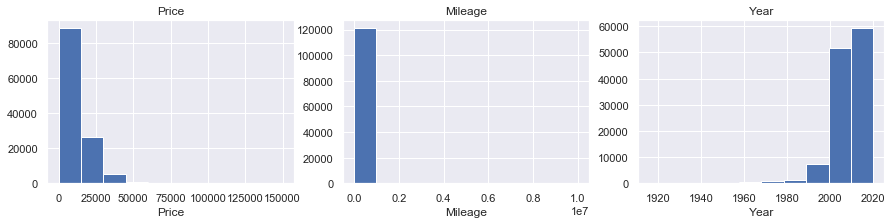

In [369]:
fig = plt.figure(figsize= (15,3))
plt.subplot(1,3,1)
df_cars_nonulls['price'].hist()
plt.title('Price')
plt.xlabel('Price')
plt.subplot(1,3,2)
plt.title('Mileage')
plt.xlabel('Mileage')
df_cars_nonulls['odometer'].hist()
plt.subplot(1,3,3)
plt.title('Year')
plt.xlabel('Year')
df_cars_nonulls['year'].hist()
plt.show()

As we can see from histogram price and odometer values are "spreaded" several orders of magnitude. We take log of those columns to deal with that. 

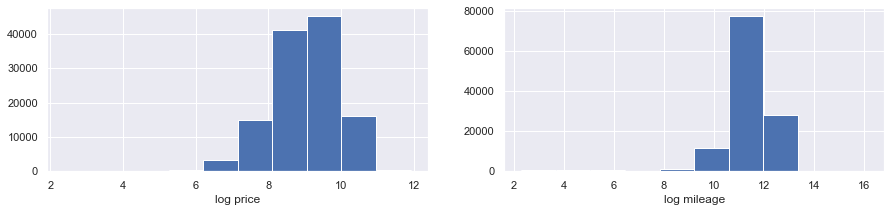

In [375]:
df_cars_nonulls['log_price'] = np.log(df_cars_nonulls['price'])
df_cars_nonulls['log_odometer'] = np.log(df_cars_nonulls['odometer']+10)

fig = plt.figure(figsize= (15,3))
plt.subplot(1,2,1)
df_cars_nonulls['log_price'].hist()
plt.xlabel('log price')
plt.subplot(1,2,2)
df_cars_nonulls['log_odometer'].hist()
plt.xlabel('log mileage')
plt.show()

## Description of clean Dataset

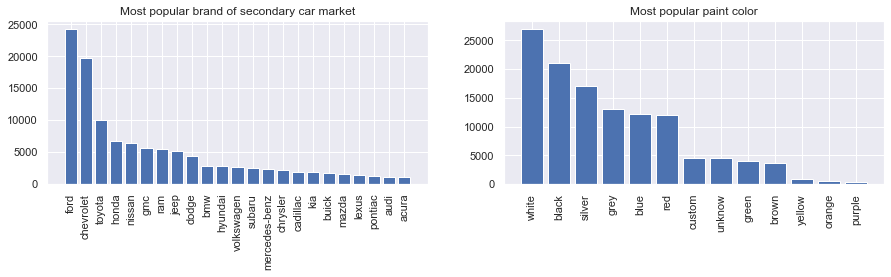

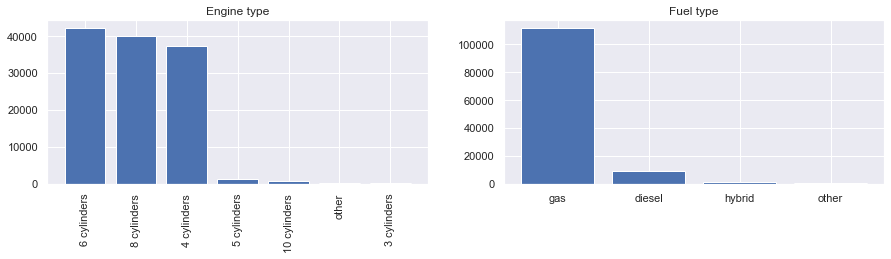

In [370]:
df_count_brabds = pd.DataFrame( {'count': df_cars_nonulls.groupby('manufacturer').size()} ).reset_index()
df_count_brabds.sort_values(by='count', ascending =False, inplace=True);
df_count_brabds =df_count_brabds[df_count_brabds['count']>1000]

fig = plt.figure(figsize= (15,3))
plt.subplot(1,2,1)
plt.title('Most popular brand of secondary car market')
plt.bar(df_count_brabds['manufacturer'],df_count_brabds['count'])
plt.xticks(rotation =90)
plt.subplot(1,2,2)
df_count_color = pd.DataFrame( {'count': df_cars_nonulls.groupby('paint_color').size()} ).reset_index()
df_count_color.sort_values(by='count', ascending =False, inplace=True);
df_count_color =df_count_color[df_count_color['count']>100]
plt.title('Most popular paint color')
plt.bar(df_count_color['paint_color'],df_count_color['count'])
plt.xticks(rotation =90);
plt.show();
df_count_eng = pd.DataFrame( {'count': df_cars_nonulls.groupby('cylinders').size()} ).reset_index()
df_count_eng.sort_values(by='count', ascending =False, inplace=True);
df_count_eng =df_count_eng[df_count_eng['count']>100]

fig = plt.figure(figsize= (15,3))
plt.subplot(1,2,1)
plt.title('Engine type')
plt.bar(df_count_eng['cylinders'],df_count_eng['count'])
plt.xticks(rotation =90);
plt.subplot(1,2,2)
df_count_fuel = pd.DataFrame( {'count': df_cars_nonulls.groupby('fuel').size()} ).reset_index()
df_count_fuel.sort_values(by='count', ascending =False, inplace=True);

df_count_fuel =df_count_fuel[df_count_fuel['count']>100]
plt.title('Fuel type')
plt.bar(df_count_fuel['fuel'],df_count_fuel['count'] );

In [371]:
mean_price = df_makemodel_dummy ['price'].mean()
mean_year=df_makemodel_dummy ['year'].mean()
mean_miles = df_makemodel_dummy ['odometer'].mean()


print('Number of records:', df_makemodel_dummy.shape[0])
print(f'Average price:     {round(mean_price,2)}$')
print(f'Average age:       {round(2019 - mean_year,2)} years')
print(f'Average mileage:   {round(mean_miles,2)} miles')

Number of records: 99255
Average price:     11706.06$
Average age:       10.36 years
Average mileage:   118452.5 miles


In [347]:
df_cars_nonulls['make_model'].nunique()

11672

As 'make_model' contains more than 11k uniques values ( too many for hot encoding). To reduce number of unique models, drop models which occur less than 10 times in the dataset:

In [348]:
df_count = pd.DataFrame( {'count': df_cars_nonulls.groupby('make_model').size()} ).reset_index()
df_count.sort_values(by='make_model', ascending =True);
pass_model_lst=list(df_count[df_count['count']>10]['make_model'].unique())
pass_model_lst=set(pass_model_lst)
df_makemodel = df_cars_nonulls[df_cars_nonulls['make_model'].isin(pass_model_lst)]
df_makemodel.drop(['manufacturer','make'],axis=1, inplace=True)
df_makemodel['make_model'].nunique()

1374

Now we have ~1300 unique models, so we can hot encode the dataset.

In [349]:
df_makemodel_dummy = pd.get_dummies(df_makemodel,drop_first=True)

In [350]:
# To accelerate modeling we select smaller sample from dataset
# 10% of dataset size
df_sample=df_makemodel_dummy.sample(frac=0.10)

X=df_sample.drop(['price','log_price','odometer'], axis=1)
Y=df_sample['log_price']

# Spliting data in train test set, with 20% test size
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)

## Modeling

In this project we are trying to predict a price of used vehicles. Because price (target variable) is continuous  variable, we should use regression model. We start with DummyRegressor model to see how just random guess ca predict outcome and to establish based line of the accuracy  


In [351]:
dumreg = DummyRegressor()
dumreg.fit(X_train, y_train)
print('Dummy train score:',dumreg.score(X_train, y_train),'\nDummy test score:', dumreg.score(X_test, y_test))


Dummy train score: 0.0 
Dummy test score: -0.0009913732201496384


Dummy model gives 0 train and test score, which indicates that target variable  can not be predicted just by random guess.

Next we test several other regression model, and compare their performance (run time and accuracy). Selected models: Ridge, ElasticNet, Support Vector Machine, Random Forest, Gradient boost and XGBoost.

In [381]:
df_results=pd.DataFrame(columns = ['RegModel', 'R-score', 'Run Time'])

### Ridge
start_time= time.time()
ridgeregr = Ridge() 
ridgeregr.fit(X_train, y_train)
run_time = time.time() -start_time
df_results = df_results.append({'RegModel':'Ridge',
                                'R-score':ridgeregr.score(X_test, y_test),
                                'Run Time':run_time},ignore_index=True)
##############################################################################

### ElasticNet
start_time= time.time()
elasticregr = ElasticNet() 
elasticregr.fit(X_train, y_train)
run_time = time.time() -start_time
df_results = df_results.append({'RegModel':'ElasticNet',
                                'R-score':elasticregr.score(X_test, y_test),
                                'Run Time':run_time},ignore_index=True)
##############################################################################

### Support Vector Regressor 
start_time= time.time()
svr_rbf = SVR()
svr_rbf.fit(X_train, y_train)
run_time = time.time() -start_time
df_results = df_results.append({'RegModel':'SVR',
                                'R-score':svr_rbf.score(X_test, y_test),
                                'Run Time':run_time},ignore_index=True)
##############################################################################


### Random Forest
start_time= time.time()
rfr = RandomForestRegressor(max_depth=15, n_estimators=150, n_jobs=3)
rfr.fit(X_train, y_train)
run_time = time.time() -start_time
df_results = df_results.append({'RegModel':'Random Forest',
                                'R-score':rfr.score(X_test, y_test),
                                'Run Time':run_time},ignore_index=True)
##############################################################################


### GradientBoost
start_time= time.time()
grbst = GradientBoostingRegressor(learning_rate=0.1, 
                                  max_depth=15, 
                                  n_estimators=150)
grbst.fit(X_train, y_train)
run_time = time.time() -start_time
df_results = df_results.append({'RegModel':'GradientBoost',
                                'R-score':grbst.score(X_test, y_test),
                                'Run Time':run_time},ignore_index=True)

##############################################################################

### XGBoost
start_time= time.time()
xgb=XGBRegressor(learning_rate=0.1, max_depth=15, n_estimators=150, 
                nthread=3)
xgb.fit(X_train, y_train)
run_time = time.time() -start_time
df_results = df_results.append({'RegModel':'XGBoost',
                                'R-score':xgb.score(X_test, y_test),
                                'Run Time':run_time},ignore_index=True)


##############################################################################
 
df_results

[10:52:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RegModel,R-score,Run Time
0,Ridge,0.623765,0.474746
1,ElasticNet,0.258887,0.324639
2,SVR,0.645718,85.903567
3,Random Forest,0.705962,16.127723
4,GradientBoost,0.677969,171.503409
5,XGBoost,0.728549,87.844908


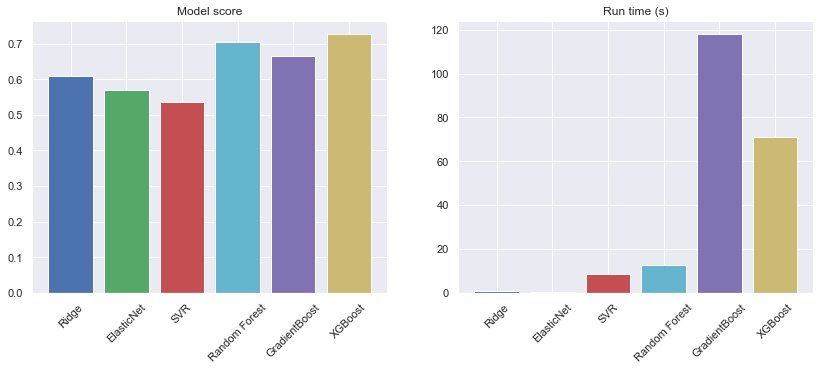

In [378]:
clr_lst = ['b','g','r','c','m','y']
fig = plt.figure(figsize= (14,5))
plt.subplot(1,2,1)
plt.title ('Model score')
plt.bar(df_results['RegModel'],df_results['R-score'],color =clr_lst)
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.title ('Run time (s)')
plt.bar(df_results['RegModel'],df_results['Run Time'], color =clr_lst)
plt.xticks(rotation=45);

Random Forest, GradientBoost  and XGBoost showed high score compared to Ridge, ElasticNet and Support Vector Machine.  These models have high score because they are based on random forest, so they can more accurately model non-linearity in data. On the other hand liner models have lower score. Besides accuracy of the model training time is other important parameter, which plays crucial role in model selection. Ridge and ElasticNet models have very low training time, but it accuracy is not good enough. 

Random forest has lower training time among non-linear models. GradientBosot is the slower of three. Despite XGBoost slower than RandomForest , we is going use it for fine tuning, because it has better tunability.  


In [385]:
# 
y_pred_test_ridge  = ridgeregr.predict(X_test)
y_pred_test_elnet  = elasticregr.predict(X_test)
y_pred_test_svr  = svr_rbf.predict(X_test)
y_pred_test_rfr  = rfr.predict(X_test)
y_pred_test_grbst  = grbst.predict(X_test)
y_pred_test_xgb  = xgb.predict(X_test)
ridge_MAE = np.exp(mean_absolute_error(y_test, y_pred_test_ridge))
elnet_MAE = np.exp(mean_absolute_error(y_test, y_pred_test_elnet))
svr_MAE = np.exp(mean_absolute_error(y_test, y_pred_test_svr))
rfr_MAE = np.exp(mean_absolute_error(y_test, y_pred_test_rfr))
grbst_MAE = np.exp(mean_absolute_error(y_test, y_pred_test_grbst))
xgb_MAE = np.exp(mean_absolute_error(y_test, y_pred_test_xgb))


df_MAE = pd.DataFrame()

df_MAE = df_MAE.append({'RegModel':'Ridge',
                                'MAE':ridge_MAE},ignore_index=True)

df_MAE  = df_MAE.append({'RegModel':'ElasticNet',
                                'MAE':elnet_MAE},ignore_index=True)

df_MAE  = df_MAE.append({'RegModel':'SVR',
                                'MAE':svr_MAE},ignore_index=True)

df_MAE  = df_MAE.append({'RegModel':'Random Forest',
                                'MAE':rfr_MAE},ignore_index=True)

df_MAE  = df_MAE.append({'RegModel':'GradientBoost',
                                'MAE':grbst_MAE},ignore_index=True)

df_MAE  = df_MAE.append({'RegModel':'XGBoost',
                                'MAE':xgb_MAE},ignore_index=True)

print("MAE Rideg: {}$".format(ridge_MAE))
print("MAE ElasticNet: {}$".format(elnet_MAE))
print("MAE SVR: {}$".format(svr_MAE))
print("MAE RandomForest: {}$".format(rfr_MAE))
print("MAE GradientBoost: {}$".format(grbst_MAE))
print("MAE XGBoost: {}$".format(xgb_MAE))

df_MAE

MAE Rideg: 1.4424198040639333$
MAE ElasticNet: 1.7918604013223243$
MAE SVR: 1.4002300997906232$
MAE RandomForest: 1.3439031841851614$
MAE GradientBoost: 1.336532182398555$
MAE XGBoost: 1.310273660817466$


,MAE,RegModel
0,1.442420,Ridge
1,1.791860,ElasticNet
2,1.400230,SVR
3,1.343903,Random Forest
4,1.336532,GradientBoost
5,1.310274,XGBoost


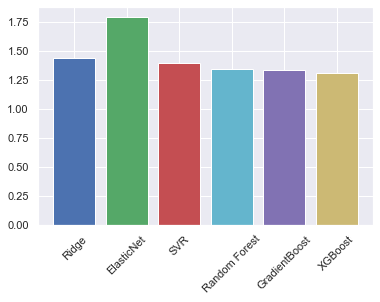

In [386]:
plt.bar(df_MAE['RegModel'],df_MAE['MAE'], color =clr_lst)
plt.xticks(rotation=45);

## Fine tuning of XGBoost model


For fine tuning XGBoost model we will run GridSearch  ranging the following parameter: learning rate, height of trees (max_depth), number of trees in the forest  (n_estimators) and regularization (reg_lambda) to reduce overfitting.






In [151]:
xgb=XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=100, 
                nthread=3,reg_lambda=2,random_state=44)

In [228]:
%%time
params = {'learning_rate':[0.05,0.1,0.3],
          'max_depth':[15], 
          'n_estimators':[150],
         'reg_lambda':[10]}
gridXG = GridSearchCV(xgb, param_grid=params, cv=3, return_train_score=True, n_jobs=3)
gridXG.fit(X, Y)
print('Best parameters:',gridXG.best_params_)
print('Best score:',gridXG.best_score_)

[09:54:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 150, 'reg_lambda': 10}
Best score: 0.7653819339269611
Wall time: 10min 41s


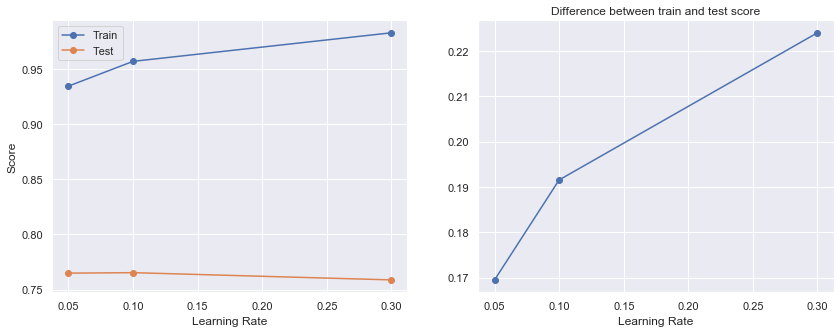

In [256]:
cv_r=pd.DataFrame(gridXG.cv_results_)

fig = plt.figure(figsize= (14,5))
plt.subplot(1,2,1)

plt.plot(cv_r['param_learning_rate'], cv_r['mean_train_score'], 'o-', label='Train')
plt.plot(cv_r['param_learning_rate'], cv_r['mean_test_score'], 'o-', label='Test')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Learning Rate')
plt.subplot(1,2,2)
plt.plot(cv_r['param_learning_rate'], cv_r['mean_train_score']-cv_r['mean_test_score'], 'o-')
plt.title('Difference between train and test score')
plt.xlabel('Learning Rate')
plt.show();

Learning rate of 0.05 gives better test score and minimal difference between train and test score.

In [ ]:
%%time
params = {'learning_rate':[0.05],
          'max_depth':[15], 
          'n_estimators':[150],
         'reg_lambda':[4,6,8,10,12]}
gridXGl = GridSearchCV(xgb, param_grid=params, cv=3, return_train_score=True, n_jobs=3)
gridXGl.fit(X, Y)

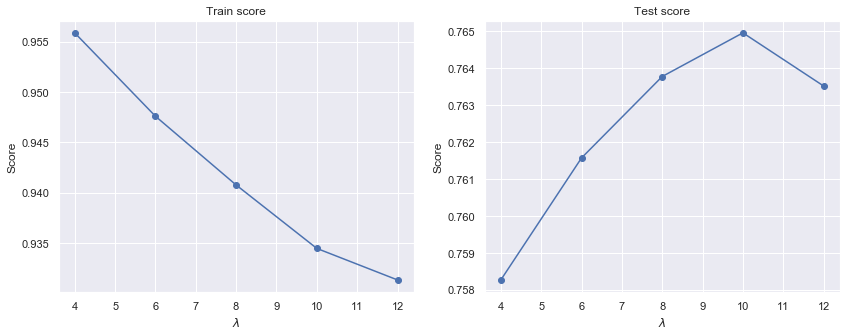

In [263]:
cv_rl=pd.DataFrame(gridXGl.cv_results_)

fig = plt.figure(figsize= (14,5))
plt.subplot(1,2,1)
plt.plot(cv_rl['param_reg_lambda'], cv_rl['mean_train_score'], 'o-', label='Train')
#plt.plot(cv_rl['param_reg_lambda'], cv_rl['mean_test_score'], 'o-', label='Test')
plt.title('Train score')
plt.xlabel(r'$\lambda$')
plt.ylabel('Score')
plt.subplot(1,2,2)
plt.plot(cv_rl['param_reg_lambda'], cv_rl['mean_test_score'], 'o-')
plt.xlabel(r'$\lambda$')
plt.title('Test score')
plt.ylabel('Score')
plt.show();

In [269]:
%%time
params = {'learning_rate':[0.05],
          'max_depth':[8,10,15,20,25], 
          'n_estimators':[150],
         'reg_lambda':[10]}
gridXGm = GridSearchCV(xgb, param_grid=params, cv=3, return_train_score=True, n_jobs=3)
gridXGm.fit(X, Y);

[16:44:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 14min 34s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=15,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=3,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=3,
             param_grid={'learning_rate': [0.05],
                         'max_depth': [8, 10, 15, 20, 25],
                  

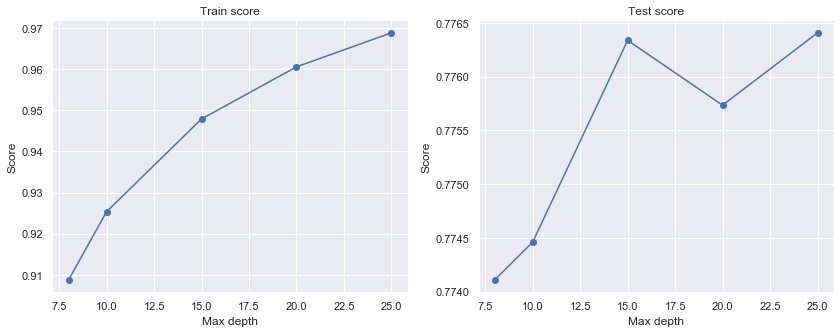

In [270]:
cv_rm=pd.DataFrame(gridXGm.cv_results_)
fig = plt.figure(figsize= (14,5))
plt.subplot(1,2,1)

plt.plot(cv_rm['param_max_depth'], cv_rm['mean_train_score'], 'o-', label='Train')
plt.title('Train score')
plt.xlabel('Max depth')
plt.ylabel('Score')

plt.subplot(1,2,2)
plt.plot(cv_rm['param_max_depth'], cv_rm['mean_test_score'], 'o-')
plt.title('Test score')
plt.xlabel('Max depth')
plt.ylabel('Score')
plt.show();

In [271]:
%%time
params = {'learning_rate':[0.05],
          'max_depth':[15], 
          'n_estimators':[100,150,200,300],
         'reg_lambda':[10]}
gridXGe = GridSearchCV(xgb, param_grid=params, cv=3, return_train_score=True, n_jobs=3)
gridXGe.fit(X, Y);

[17:02:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 16min 28s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=15,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=3,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=3,
             param_grid={'learning_rate': [0.05], 'max_depth': [15],
                         'n_estimators': [100, 150, 200, 3

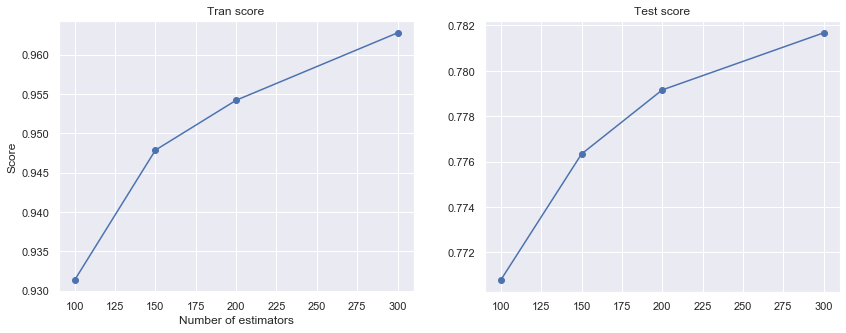

In [277]:
cv_re=pd.DataFrame(gridXGe.cv_results_)

fig = plt.figure(figsize= (14,5))
plt.subplot(1,2,1)
plt.title('Tran score')
plt.plot(cv_re['param_n_estimators'], cv_re['mean_train_score'], 'o-')
plt.ylabel('Score')
plt.xlabel('Number of estimators')
plt.subplot(1,2,2)
plt.title('Test score')
plt.plot(cv_re['param_n_estimators'], cv_re['mean_test_score'], 'o-')
plt.show();

After tuning hyper parameters of XGBoost model we found a set of hyper parameters which gives the best test score. Because GridSearchCV takes a lot time to run over large parameter space, we ran GridSearch on sample dataset 15% of the size of original dataset. Now we can run XGBoost on the entire dataset with  optimal hyperparameter to find score of the model. 

In [354]:
%%time

Xf=df_makemodel_dummy.drop(['price','log_price','odometer'], axis=1)
Yf=df_makemodel_dummy['log_price']

X_trainf, X_testf, y_trainf, y_testf = train_test_split(Xf,Yf, test_size=0.2)

xgbf=XGBRegressor(learning_rate=0.05, max_depth=20, n_estimators=200, 
                nthread=3,reg_lambda=10,random_state=44)
results_xgbf=xgbf.fit(X_trainf, y_trainf)

print('Train score:',xgbf.score(X_trainf, y_trainf))
print('Test score:',xgbf.score(X_testf, y_testf))

[14:43:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train score: 0.9107997758802024
Test score: 0.8424369208240481
Wall time: 21min 30s


In [327]:

print("Mean absolute error of the prediction is: {}$".format( 
    (np.exp(mean_absolute_error(y_pred_test,y_testf)))))

Mean absolute error of the prediction is: 1.297289078798168$


## Error analysis 

In [392]:
y_pred_train = xgbf.predict(X_trainf)
y_pred_test = xgbf.predict(X_testf)

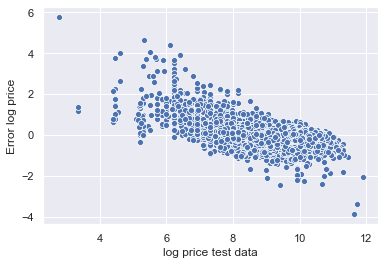

In [396]:
sns.scatterplot(x=y_testf, y =y_pred_test-y_testf)
plt.xlabel('log price test data')
plt.ylabel('Error log price');

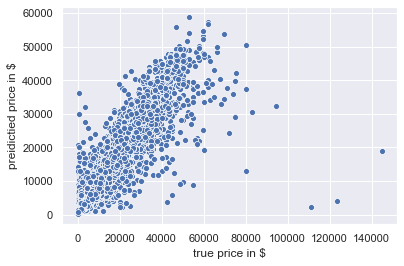

In [397]:
sns.scatterplot(x=np.exp(y_testf), y =np.exp(y_pred_test))
plt.xlabel('true price in $')
plt.ylabel('preidictied price in $');

From the plot above we can see that model does not predict well prices over $80k, because dataset does not contains enough expensive cars for good model training.

### Summary 



In summary based on information of used vehicles from craigslist I build predictive model which help help to estimate prices of used vehicles.  XGBoost model gives the best performance with the best accuracy of 0.84 and mean absolute error only of 1.3$ in price prediction.

This model could be useful for people who wants to buy used car or sell their cars, as well for dealers and other car businesses. For further improvement of the model and increase it accuracy and versatility dataset with more features is need. Such thing if car has some customization, tuning or upgrades would be very interesting for car enthusiasts.  
 